In [1]:
# Install requirements
!pip install -r "/kaggle/input/transfer-proj-depend/requirements.txt" | grep -v "already satisfied"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 67.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 20.9 MB/s

In [2]:
!pip install -U numpy
!pip install --upgrade torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 74.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.0 which is incompatible.
featuretools 1.27.0 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.3.5 which is incompatible.
fitter 1.6.0 requires tqdm<5.0.0,>=4.65.1, but you have tqdm 4.63.0 which is incompatible.
geoviews 1.10.1 requires bokeh<3.3.0,>=3.1.0, but you have bokeh 2.1.1 which is incompatible.
imageio 2.31.1 

In [1]:
import sys
sys.path.insert(1, "/kaggle/input/transfer-proj-depend/src")
import src

In [2]:
# Imports here
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
# import helper
from torchvision import datasets, transforms, models

In [3]:
data_dir = '/kaggle/input/intel-image-classification'
train_dir = data_dir + '/seg_train/seg_train'
pred_dir = data_dir + '/seg_pred'
test_dir = data_dir + '/seg_test/seg_test'

In [4]:
# experiment with different data augnmentation techniques:- refer https://pytorch.org/vision/master/transforms.html

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

data_transforms = {
        "train": transforms.Compose(
            # YOUR CODE HERE
            [transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomAffine(degrees=(-2, 2), translate=(0.05, 0.05), scale=(0.97, 1.03), shear=(-1, 1)),
            transforms.ColorJitter(brightness=(0.95, 1.05), contrast=(0.95, 1.05)),
            transforms.RandomGrayscale(p=0.03),
            transforms.GaussianBlur(9),
            transforms.RandomInvert(p=0.05),
            transforms.RandomHorizontalFlip(p=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(),std.tolist())
            ]
        ),
        "valid": transforms.Compose(
            # YOUR CODE HERE
            [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(),std.tolist())
            ]
        ),
        "test": transforms.Compose(
            # YOUR CODE HERE
            [transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(),std.tolist())
            ]
        ),
    }

# data_transforms =  transforms.Compose([transforms.CenterCrop(224),
#                                       transforms.Resize(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406],
#                                                           [0.229, 0.224, 0.225])])

image_datasets = datasets.ImageFolder(data_dir, transform = data_transforms['train'])

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size = 24, shuffle = True) 

In [5]:
img_train_datasets = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
img_test_datasets = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

img_train_datasets, img_valid_datasets = torch.utils.data.random_split(img_train_datasets, [0.75,0.25])

In [6]:
trainloader = torch.utils.data.DataLoader(img_train_datasets, batch_size = 50, shuffle = True)   

validloader = torch.utils.data.DataLoader(img_valid_datasets, batch_size = 50, shuffle = True)   

testloader = torch.utils.data.DataLoader(img_test_datasets, batch_size = 50, shuffle = True)   

In [7]:
images, labels = next(iter(trainloader))
# images = images.view(images.shape[0], - 1)
images.shape

torch.Size([50, 3, 224, 224])

In [8]:
images, labels = next(iter(testloader))
# images = images.view(images.shape[0], - 1)
images.shape

torch.Size([50, 3, 224, 224])

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

def visualize_one_batch(data_loader, batch_size):
    # Get a batch of data from the data loader
    data_iter = iter(data_loader['train'])
    images, labels = next(data_iter)

    # Create a grid of images
    grid = vutils.make_grid(images[:batch_size], normalize=True)

    # Convert the grid to a numpy array
    grid = grid.numpy()

    # Transpose the dimensions of the grid to match the expected format
    grid = np.transpose(grid, (1, 2, 0))

    # Display the grid of images
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

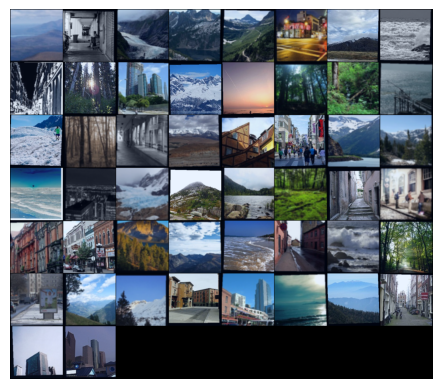

In [10]:
data_loader = {
                'train': trainloader,
                'valid': validloader,
                'test': testloader
              }

visualize_one_batch(data_loader,50)

In [11]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 6, dropout: float = 0.4976) -> None:

        super().__init__()

        # YOUR CODE HERE
        # Define a CNN architecture. Remember to use the variable num_classes
        # to size appropriately the output of your classifier, and if you use
        # the Dropout layer, use the variable "dropout" to indicate how much
        # to use (like nn.Dropout(p=dropout))
        self.backbone = nn.Sequential(
                            nn.Conv2d(3, 16, 3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2, 2),
                            #nn.BatchNorm2d(64),
                            #nn.Dropout2d(p=dropout),
                            nn.Conv2d(16, 32, 3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2, 2),
                            #nn.BatchNorm2d(128),
                            #nn.Dropout2d(p=dropout),
                            nn.Conv2d(32, 64, 3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2, 2),
                            #nn.BatchNorm2d(256),
                            #nn.Dropout2d(p=dropout),
                            nn.Conv2d(64, 128, 3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2, 2),#,
                            #nn.BatchNorm2d(512)
                            nn.Conv2d(128, 256, 3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2, 2)
                        )
        
        self.adjust = nn.AdaptiveAvgPool2d((10,10))
        
        self.head = nn.Sequential(nn.Linear(25600, 1024),
                                  nn.ReLU(),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(1024,500),
                                  nn.ReLU(),
                                  nn.Dropout(p=dropout),
#                                   nn.Linear(500, 50),
#                                   nn.ReLU(),
#                                   nn.Dropout(p=dropout),
                                  nn.Linear(500, num_classes),
                                  nn.ReLU()
                                  #nn.Softmax(dim=1)
                                  )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE: process the input tensor through the
        # feature extractor, the pooling and the final linear
        # layers (if appropriate for the architecture chosen)
        x = self.backbone(x)
        x = self.adjust(x)
        x = x.view(x.shape[0], -1)
        x = self.head(x)
        return x

In [12]:
model = MyModel()
out = model(images)
_, out_classes = out.topk(1,dim=1)
out_classes

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

In [14]:
!pip install livelossplot

In [16]:
num_epochs = 15        # number of epochs for training
num_classes = 6       # number of classes. Do not change this
dropout = 0.03          # dropout for our model
learning_rate = 0.009  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 7e-3     # regularization. Increase this to combat overfitting
momentum = 0.9

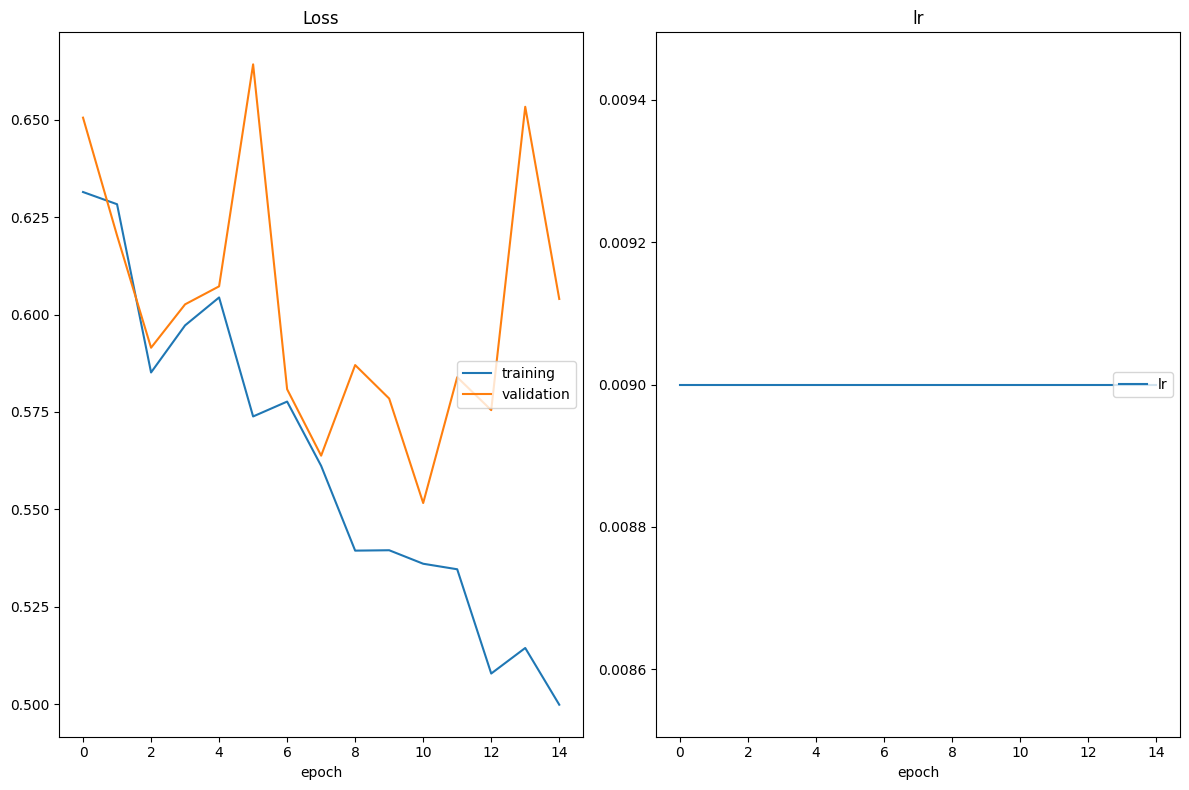

In [23]:
from src.optimization import get_optimizer, get_loss
from src.train import optimize

model = MyModel(num_classes, dropout)
#run this after running first training epoch and creating saved checkpoint file in .pt format
model.load_state_dict(torch.load('/kaggle/input/checkpoint-saved-intel-dataset/best_val_loss.pt'))

optimizer = get_optimizer(model, opt, learning_rate, momentum, weight_decay)

loss = get_loss()

optimize(
    data_loader,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="/kaggle/working/best_val_loss.pt",
    interactive_tracking=True
)

In [24]:
from src.train import one_epoch_test
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model_dict = torch.load('/kaggle/working/best_val_loss.pt')
model.load_state_dict(model_dict)

# Run test
one_epoch_test(data_loader['test'], model, loss)

Testing: 100%|██████████████████████████████████| 60/60 [00:14<00:00,  4.08it/s]

Test Loss: 0.492719


Test Accuracy: 83% (2513/3000)


0.49271923104921983

In [25]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
import torch

# First let's get the class names from our data loaders
class_names = data_loader["train"].dataset.dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=6, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
mod = torch.load("/kaggle/working/best_val_loss.pt", map_location="cpu")

# YOUR CODE HERE
model.load_state_dict(mod)

# Let's wrap our model using the predictor class
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor) # YOUR CODE HERE

scripted_predictor.save("/kaggle/working/original_exported.pt")

In [26]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("/kaggle/working/original_exported.pt") # YOUR CODE HERE

In [27]:
from tqdm import tqdm

def predictor_test(test_dataloader, model_reloaded):
    """
    Test the predictor. Since the predictor does not operate on the same tensors
    as the non-wrapped model, we need a specific test function (can't use one_epoch_test)
    """

    pred = np.zeros(len(img_test_datasets))
    truth = np.zeros(len(img_test_datasets))
    ptr = 0
    for x, y in test_dataloader:
        inc = len(y)
        softmax = model_reloaded(x)
        _, idx = softmax.topk(1,dim=1)
        idx = idx.squeeze(dim=1)

        pred[ptr:ptr+inc] = idx
        truth[ptr:ptr+inc] = y
        
        ptr += inc

    return truth, pred


pred, truth = predictor_test(data_loader['test'], model_reloaded)

code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass an

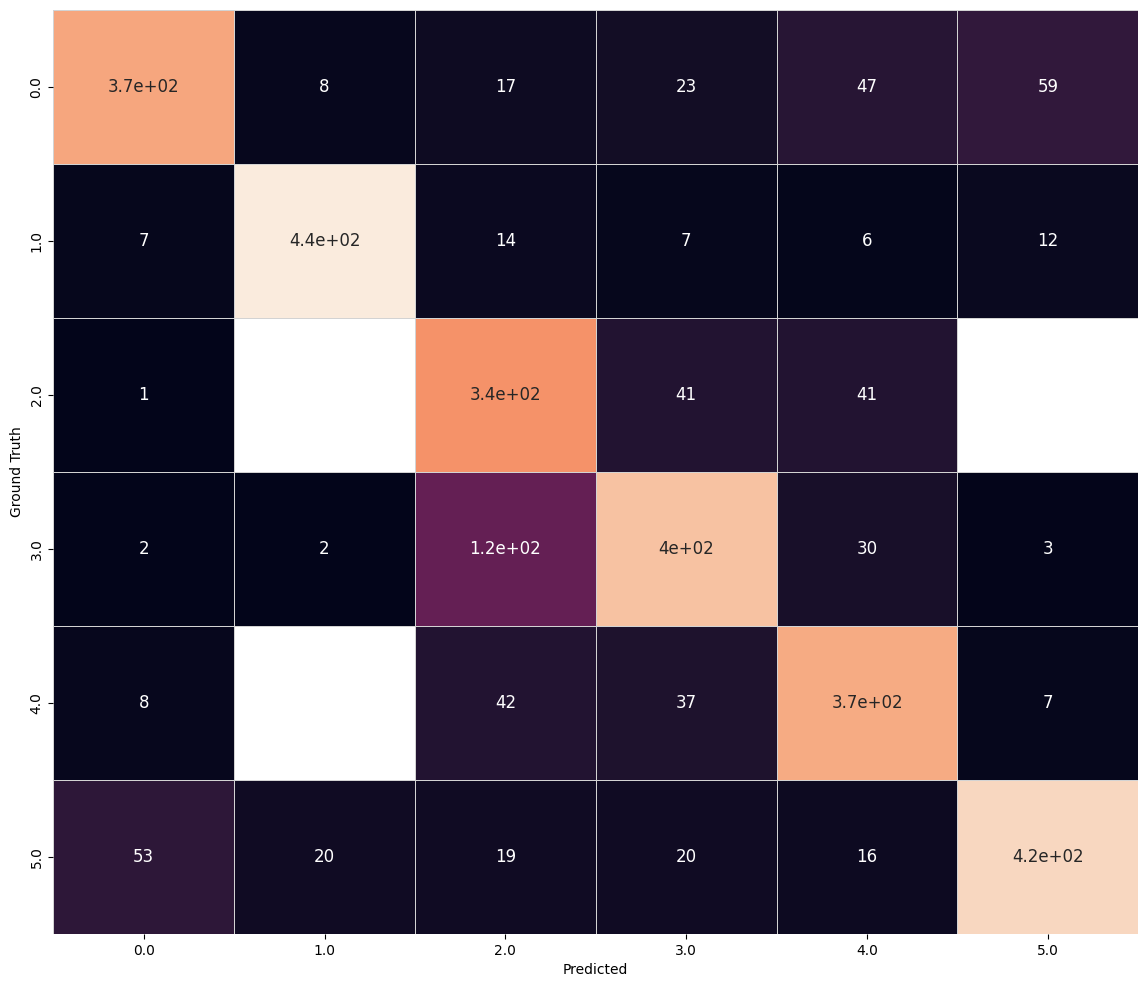

In [28]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)

In [1]:
# confirmed that the package contains the most recent checkpoint (model with accuracy 83%)

In [20]:
pred_image_datasets = datasets.ImageFolder(pred_dir, transform = data_transforms['test'])

pred_dataloader = torch.utils.data.DataLoader(pred_image_datasets, batch_size = 50, shuffle = True)

In [21]:
pred_classes = data_loader['train'].dataset.dataset.classes
pred_classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [22]:
model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model_dict = torch.load('/kaggle/input/checkpoint-saved-intel-dataset/best_val_loss.pt')
model.load_state_dict(model_dict)
model.eval()
with torch.no_grad():
    x, _ = next(iter(pred_dataloader))
    out = model(x)
    _, class_top = out.topk(1, dim=1)

In [24]:
#printing the predictions 
print('Predicted classes for given set of images are:-')
size = class_top.shape
s1 = size[0]
l = []
for i in range(s1):
    a = class_top[i][0]
    l.append(pred_classes[int(a)])
print(l)

Predicted classes for given set of images are:-
['buildings', 'sea', 'mountain', 'buildings', 'forest', 'sea', 'mountain', 'forest', 'buildings', 'mountain', 'sea', 'street', 'buildings', 'sea', 'buildings', 'street', 'forest', 'forest', 'forest', 'forest', 'buildings', 'mountain', 'buildings', 'mountain', 'glacier', 'glacier', 'buildings', 'glacier', 'glacier', 'buildings', 'street', 'sea', 'street', 'buildings', 'sea', 'sea', 'glacier', 'mountain', 'street', 'forest', 'street', 'sea', 'buildings', 'forest', 'forest', 'forest', 'forest', 'street', 'street', 'mountain']
